In [16]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from WISE_tools import *

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
len(good)

6484

In [3]:
lightcurve_directory = '../data/WISE_lcs/'
source_names = parse_source_names(lightcurve_directory)
print(source_names[0],len(source_names))

J000041.86+554320.8 6484


/Users/carina/Research/UW/GaiaSprintMassive/WISE/code/WISE_tools.py:81: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dfs)


<ErrorbarContainer object of 3 artists>

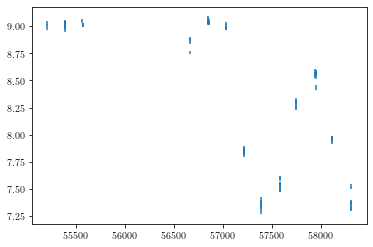

In [4]:
lc = get_lightcurve(source_names[4],lightcurve_directory)
plt.errorbar(lc['mjd'],lc['w1mpro'],lc['w1sigmpro'],ls='')
#print(lc['cc_flags'].astype(object).astype(str).str[0:2])
#(lc['cc_flags'].astype(object).astype(str).str[0:2] == '00') | (lc['cc_flags'].astype(object).astype(str).str[0:2] == '0')

In [5]:
def mean_per_visit(time,mag,err,dt_tol=50):
    """
    Calculates the mean per-visit point.
    
    Assume some delta time over which something is considered a separate visit.
    """
    visits = []
    visit = np.array([[time[0],mag[0],err[0]]])
    for i in range(1,len(time)):
        dif = time[i] - time[i-1]
        if dif <= dt_tol:
            visit = np.append(visit,[[time[i],mag[i],err[i]]],axis=0)
        else:
            visits.append(visit)
            visit = np.array([[time[i],mag[i],err[i]]])
    visits.append(visit)
    visits = np.array(visits)
    mean_times = []
    mean_mags = []
    mean_errs = []
    for visit in visits:
        mean_times.append(np.mean(visit[:,0]))
        mean_mags.append(np.mean(visit[:,1]))
        mean_errs.append(np.sqrt(np.sum(np.power(visit[:,2],2.0)))/len(visit))
    return np.array(mean_times),np.array(mean_mags),np.array(mean_errs)


502.49968487603104 177.78671993077558 7 0.0022523449691137505


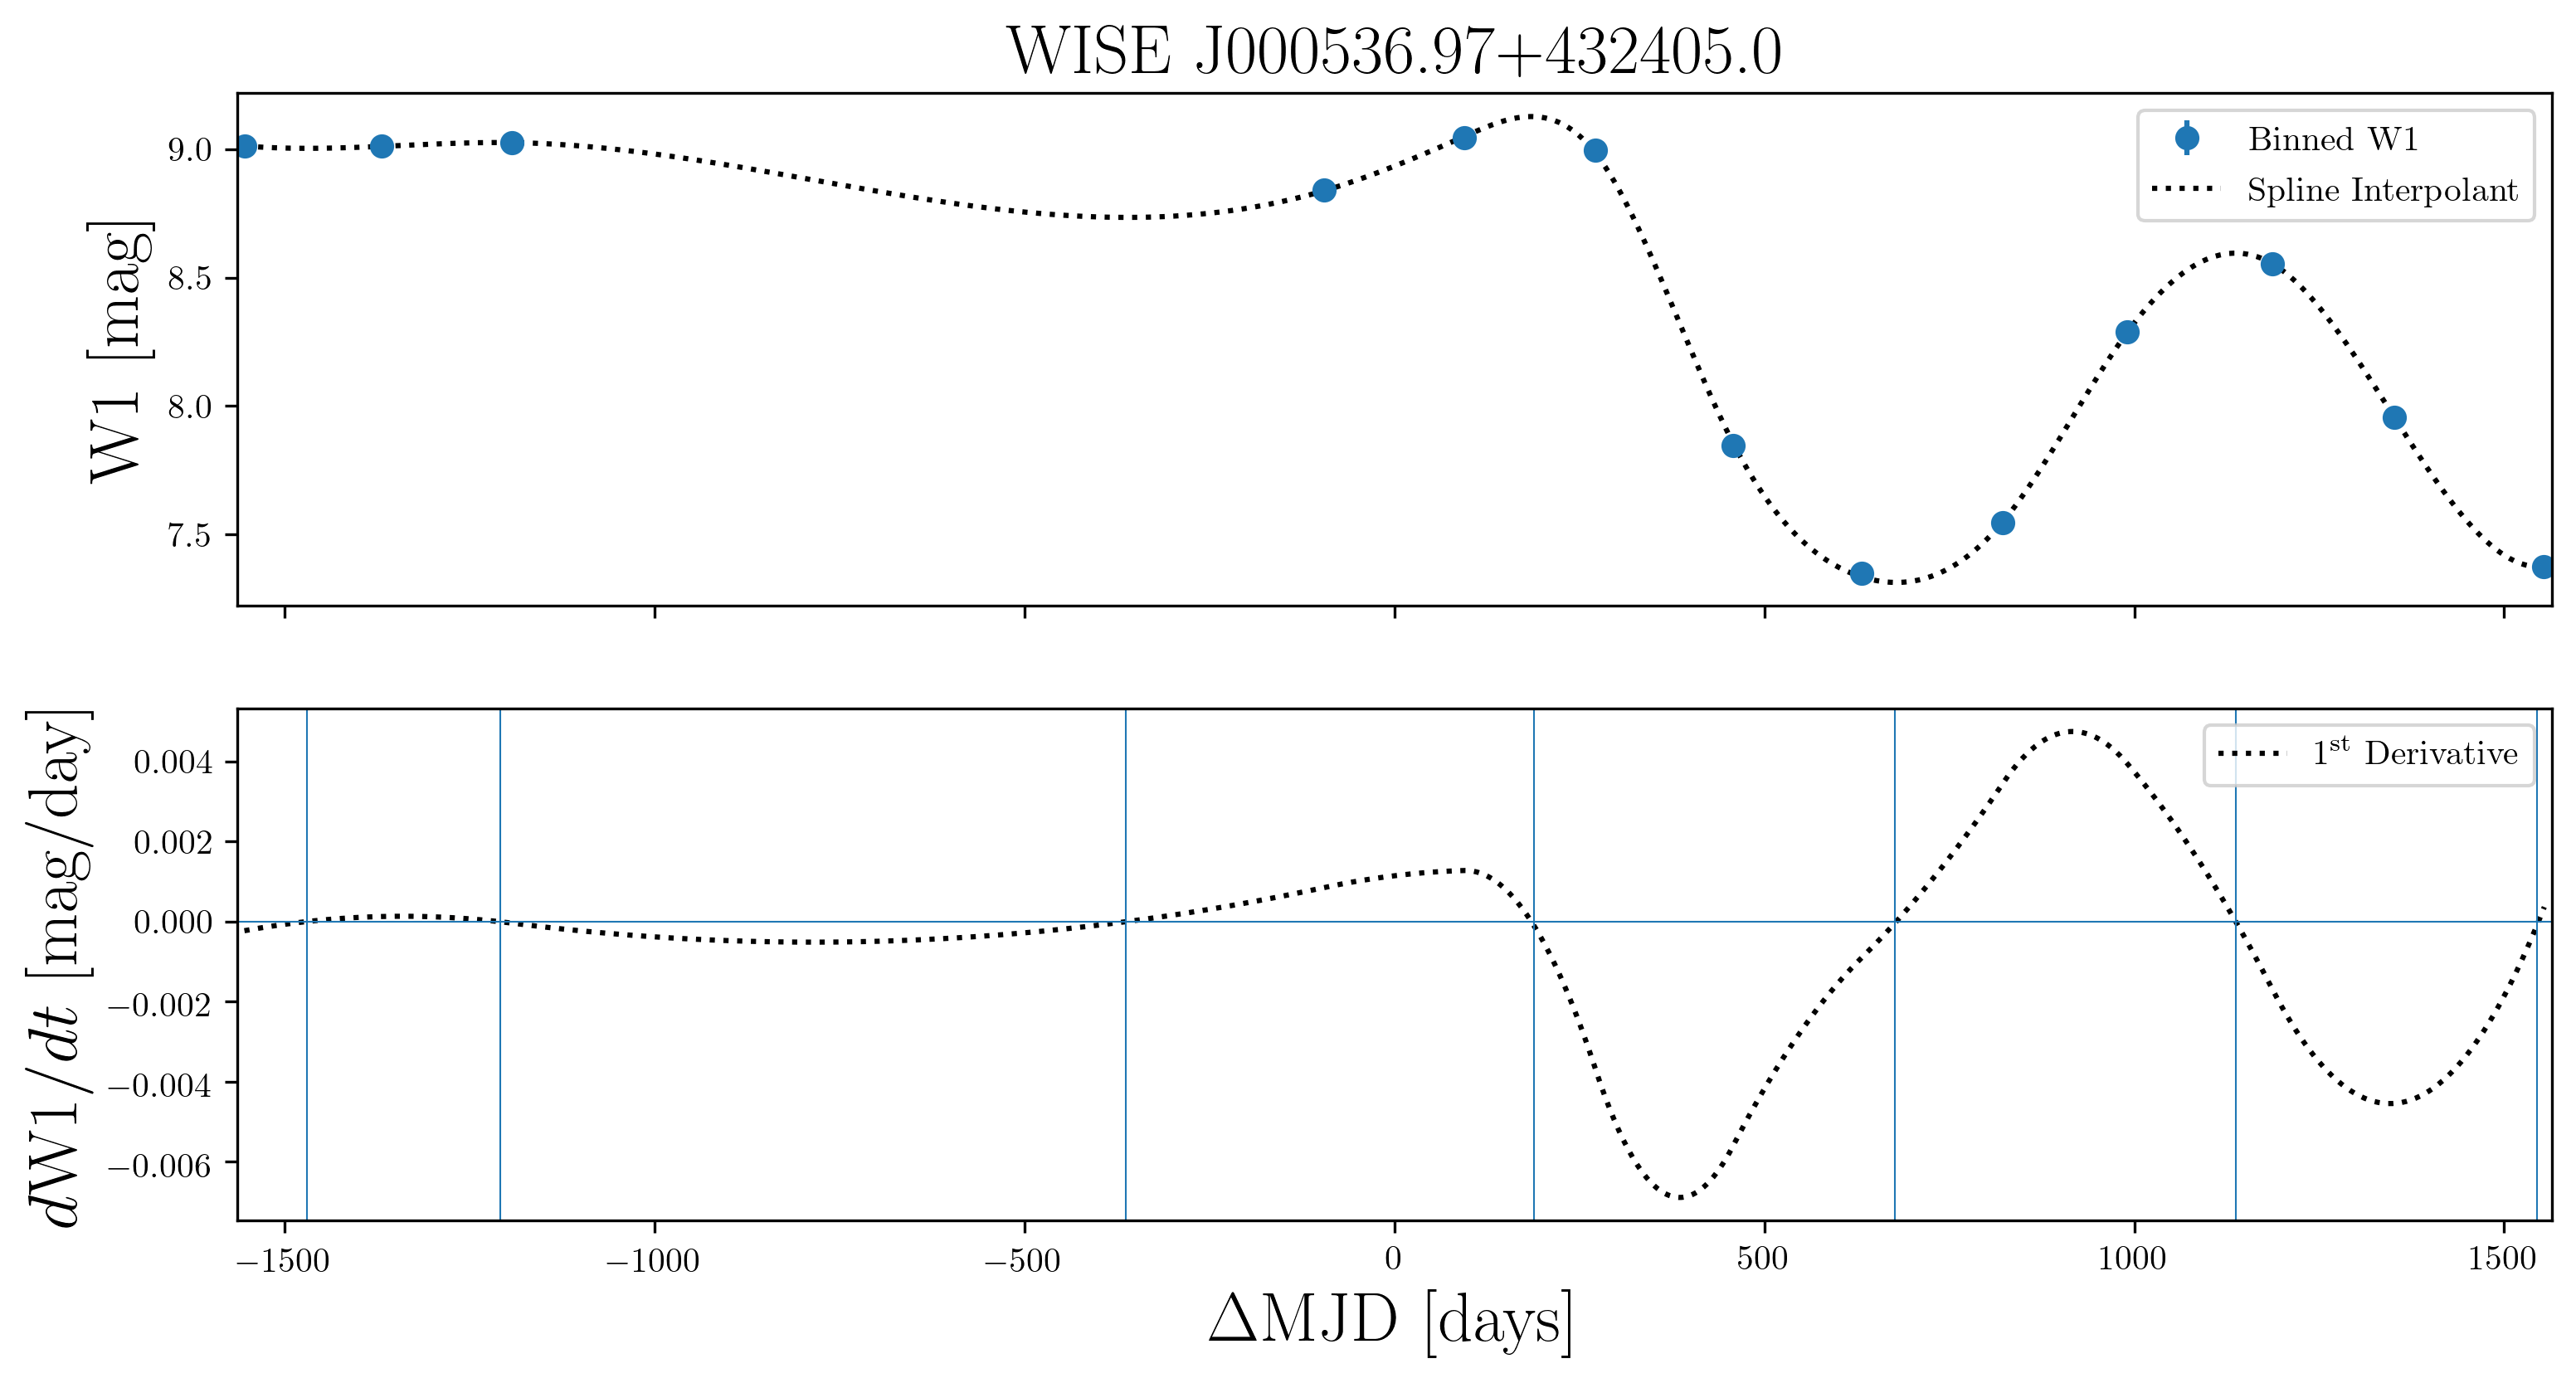

In [6]:
from scipy import interpolate
fig,ax = plt.subplots(2,1,figsize=(12,6),dpi=300,sharex=True)
t, m, e = lc['mjd'].values, lc['w1mpro'].values, lc['w1sigmpro'].values
t_sub = t - 0.5*(t[0] + t[-1])
mt,mm,me = mean_per_visit(t_sub,m,e)
tck = interpolate.splrep(mt, mm, w=1.0/me, s=10)
ts = np.linspace(t_sub[0],t_sub[-1],1000)
mfit = interpolate.splev(ts, tck, der=0)

ax[0].plot(ts,mfit,':k',label='Spline Interpolant')
ax[0].errorbar(mt,mm,me,ls='',fmt='o',label='Binned W1')

h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
ax[0].set_ylabel('W1 [mag]',fontsize=20)

mfit_der = interpolate.splev(ts, tck, der=1)
ax[1].plot(ts,mfit_der,':k',label=r'1$^{\rm st}$ Derivative')
mfit_zeros = []
for i, d in enumerate(mfit_der[:-1]):
    if np.sign(d) != np.sign(mfit_der[i+1]):
        test_times = np.linspace(ts[i],ts[i+1],100)
        test_mfit = interpolate.splev(test_times,tck,der=1)
        mfit_zeros.append(test_times[np.argmin(test_mfit)])
zeros_diff = np.diff(mfit_zeros)
print(np.mean(zeros_diff),np.std(zeros_diff),len(mfit_zeros),len(mfit_zeros)/(max(mt)-min(mt)))
for z in mfit_zeros:
    ax[1].axvline(z,lw=0.5)
ax[1].axhline(0,lw=0.5)
ax[1].set(xlim=(ts.min()-10,ts.max()+10))
ax[1].legend()
ax[1].set_xlabel('$\Delta$MJD [days]',fontsize=20)
ax[1].set_ylabel(r'$d{\rm W1}/dt$ [mag/day]',fontsize=20)
ax[0].set_title('WISE J000536.97+432405.0', fontsize=20)
plt.savefig('../plots/timescale_lc.pdf')

```python
N_visits = []
w1_nzero = []
w1_mean_dt = []
w1_logmdt = []
w1_std_dt = []
w1_logstd = []
w2_nzero = []
w2_mean_dt = []
w2_logmdt = []
w2_std_dt = []
w2_logstd = []
color_nzero = []
color_mean_dt = []
color_logmdt = []
color_std_dt = []
color_logstd = []
from tqdm.notebook import tqdm
for name in tqdm(source_names):
    
    lc = get_lightcurve(name,lightcurve_directory)
    
    t, w1, w1e, w2, w2e, w12, w12e = [lc['mjd'].values, lc['w1mpro'].values, 
                                      lc['w1sigmpro'].values, lc['w2mpro'].values, 
                                      lc['w2sigmpro'].values, lc['w1w2'].values, 
                                      lc['w1w2err'].values]
    if len(t) == 0:
        N_visits.append(0)
        w1_nzero.append(np.nan)
        w1_mean_dt.append(np.nan)
        w1_logmdt.append(np.nan)
        w1_std_dt.append(np.nan)
        w1_logstd.append(np.nan)
        w2_nzero.append(np.nan)
        w2_mean_dt.append(np.nan)
        w2_logmdt.append(np.nan)
        w2_std_dt.append(np.nan)
        w2_logstd.append(np.nan)
        color_nzero.append(np.nan)
        color_mean_dt.append(np.nan)
        color_logmdt.append(np.nan)
        color_std_dt.append(np.nan)
        color_logstd.append(np.nan)
        continue
        
    t_sub = t - 0.5*(t[0] + t[-1]) #so that lc is centered on zero

    ts = np.linspace(t_sub[0],t_sub[-1],1000)

    mt, mw1m, mw1e = mean_per_visit(t_sub, w1, w1e)
    _, mw2m, mw2e = mean_per_visit(t_sub, w2, w2e)
    _, mw12m, mw12e = mean_per_visit(t_sub, w12, w12e)
    
    dt = np.max(mt) - np.min(mt)
    
    N_visit = len(mt)
    
    if N_visit <= 3:
        N_visits.append(N_visit)
        w1_nzero.append(np.nan)
        w1_mean_dt.append(np.nan)
        w1_logmdt.append(np.nan)
        w1_std_dt.append(np.nan)
        w1_logstd.append(np.nan)
        w2_nzero.append(np.nan)
        w2_mean_dt.append(np.nan)
        w2_logmdt.append(np.nan)
        w2_std_dt.append(np.nan)
        w2_logstd.append(np.nan)
        color_nzero.append(np.nan)
        color_mean_dt.append(np.nan)
        color_logmdt.append(np.nan)
        color_std_dt.append(np.nan)
        color_logstd.append(np.nan)
        continue
    
    tck_w1 = interpolate.splrep(mt, mw1m, w=1.0/mw1e, s=10)
    tck_w2 = interpolate.splrep(mt, mw2m, w=1.0/mw2e, s=10)
    tck_w12 = interpolate.splrep(mt, mw12m, w=1.0/mw12e, s=10)

    splder_w1 = interpolate.splev(ts, tck_w1, der=1)
    splder_w2 = interpolate.splev(ts, tck_w2, der=1)
    splder_w12 = interpolate.splev(ts, tck_w12, der=1)

    derzero_w1 = []
    derzero_w2 = []
    derzero_w12 = []

    for i, [d1, d2, d12] in enumerate(zip(splder_w1[:-1],splder_w2[:-1],splder_w12[:-1])):
        if np.sign(d1) != np.sign(splder_w1[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w1,der=1)
            derzero_w1.append(test_times[np.argmin(test_mfit)])
        if np.sign(d2) != np.sign(splder_w2[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w2,der=1)
            derzero_w2.append(test_times[np.argmin(test_mfit)])
        if np.sign(d12) != np.sign(splder_w12[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w12,der=1)
            derzero_w12.append(test_times[np.argmin(test_mfit)])
            
    Nzero_w1 = len(derzero_w1)/dt
    Nzero_w2 = len(derzero_w2)/dt
    Nzero_w12 = len(derzero_w12)/dt

    w1_diff = np.diff(derzero_w1)
    w2_diff = np.diff(derzero_w2)
    w12_diff = np.diff(derzero_w12)

    mean_dt_w1, std_dt_w1 = np.mean(w1_diff), np.std(w1_diff)
    mean_dt_w2, std_dt_w2 = np.mean(w2_diff), np.std(w2_diff) 
    mean_dt_w12, std_dt_w12 = np.mean(w12_diff), np.std(w12_diff) 

    N_visits.append(N_visit)
    w1_nzero.append(Nzero_w1)
    w1_mean_dt.append(mean_dt_w1)
    w1_logmdt.append(np.log10(mean_dt_w1))
    w1_std_dt.append(std_dt_w1)
    w1_logstd.append(np.log10(std_dt_w1))
    w2_nzero.append(Nzero_w2)
    w2_mean_dt.append(mean_dt_w2)
    w2_logmdt.append(np.log10(mean_dt_w2))
    w2_std_dt.append(std_dt_w2)
    w2_logstd.append(np.log10(std_dt_w2))
    color_nzero.append(Nzero_w12)
    color_mean_dt.append(mean_dt_w12)
    color_logmdt.append(np.log10(mean_dt_w12))
    color_std_dt.append(std_dt_w12)
    color_logstd.append(np.log10(std_dt_w12))
        
timescale_df = pd.DataFrame({'WISE_Designation':source_names,'N_visits':N_visits,
                             'W1_Nzeroes':w1_nzero,'W1_meanDt':w1_mean_dt,'W1_log_meanDt':w1_logmdt,
                             'W1_stdDt':w1_std_dt,'W1_log_stdDt':w1_logstd,
                             'W2_Nzeroes':w2_nzero,'W2_meanDt':w2_mean_dt,'W2_log_meanDt':w2_logmdt,
                             'W2_stdDt':w2_std_dt,'W2_log_stdDt':w2_logstd,
                             'W1-W2_Nzeroes':color_nzero,'W1-W2_meanDt':color_mean_dt,'W1-W2_log_meanDt':color_logmdt,
                             'W1-W2_stdDt':color_std_dt,'W1-W2_log_stdDt':color_logstd})
timescale_df.to_csv('timescales.csv', index=False)

```

In [36]:
timescale_df = pd.read_csv('timescales.csv')
timescale_df.columns

Index(['WISE_Designation', 'N_visits', 'W1_Nzeroes', 'W1_meanDt',
       'W1_log_meanDt', 'W1_stdDt', 'W1_log_stdDt', 'W2_Nzeroes', 'W2_meanDt',
       'W2_log_meanDt', 'W2_stdDt', 'W2_log_stdDt', 'W1-W2_Nzeroes',
       'W1-W2_meanDt', 'W1-W2_log_meanDt', 'W1-W2_stdDt', 'W1-W2_log_stdDt'],
      dtype='object')

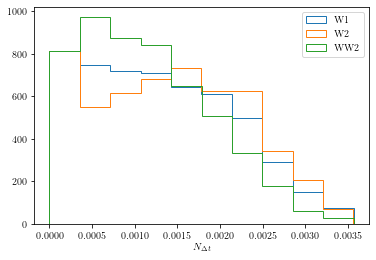

In [9]:
plt.hist(timescale_df.dropna()['W1_Nzeroes'],histtype='step',label='W1')
plt.hist(timescale_df.dropna()['W2_Nzeroes'],histtype='step',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_Nzeroes'],histtype='step',label='WW2')
plt.xlabel(r'$N_{\Delta t}$')
plt.legend()

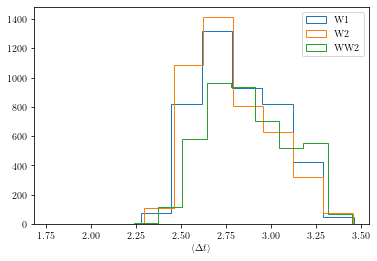

In [37]:
plt.hist(timescale_df.dropna()['W1_log_meanDt'],histtype='step',label='W1')
plt.hist(timescale_df.dropna()['W2_log_meanDt'],histtype='step',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_log_meanDt'],histtype='step',label='WW2')
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.legend()

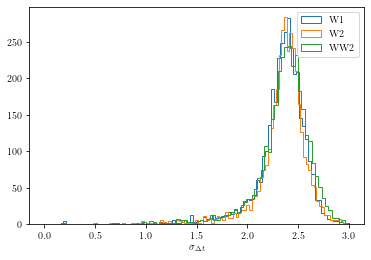

In [46]:
plt.hist(timescale_df.dropna()['W1_log_stdDt'],range=(0,3),histtype='step',bins='auto',label='W1')
plt.hist(timescale_df.dropna()['W2_log_stdDt'],range=(0,3),histtype='step',bins='auto',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_log_stdDt'],range=(0,3),histtype='step',bins='auto',label='WW2')
plt.xlabel(r'$\sigma_{\Delta t}$')
plt.legend()

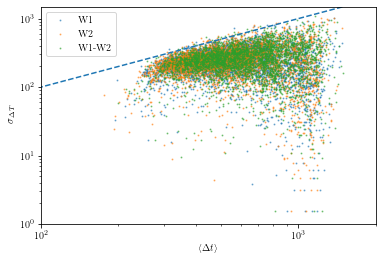

In [12]:
plt.plot([0,2000],[0,2000],ls='--')
plt.scatter(timescale_df['W1_meanDt'],timescale_df['W1_stdDt'],s=1,label='W1',alpha=0.5)
plt.scatter(timescale_df['W2_meanDt'],timescale_df['W2_stdDt'],s=1,label='W2',alpha=0.5)
plt.scatter(timescale_df['W1-W2_meanDt'],timescale_df['W1-W2_stdDt'],s=1,label='W1-W2',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,2000)
plt.ylim(1e0,1500)
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.ylabel(r'$\sigma_{\Delta T}$')
plt.legend()

In [13]:
def cdf(array, norm=True):
    """
    Calculates the cumulative density function of a given array. Default behavior is to
    normalize the CDF for easy comparison between arrays of different sizes
    
    Parameters
    ----------
    array : array-like
        Array to calculate CDF of
        
    norm : bool
        Whether to normalize by the size of array. Default True.
    
    Returns
    -------
    vals : array-like
        Abcissa of density
    density : array-like
        Values of CDF
    
    """
    
    vals = np.sort(array[~np.isnan(array)])
    
    density = np.array([i+1 for i in range(len(vals))])
    
    if norm:
        density = density/len(vals)
        
    mean_dif = np.mean(np.diff(vals))
    
    vals = np.insert(vals, 0, np.min([0,vals[0]]))#np.min([0,vals[0]-mean_dif]))
    density = np.insert(density, 0, 0)
        
    return vals, density

In [14]:
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
joined.columns

Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
       'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
       'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
       'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
       'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
       'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
       'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'CommonName_y', 'Class',
       'CoarseClass', 'IsBinary', 'WISE_Designation', 'N_visits', 'W1_Nzeroes',
       'W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt',
       'W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt'],
      dtype='object')

Text(0, 0.5, 'CDF')

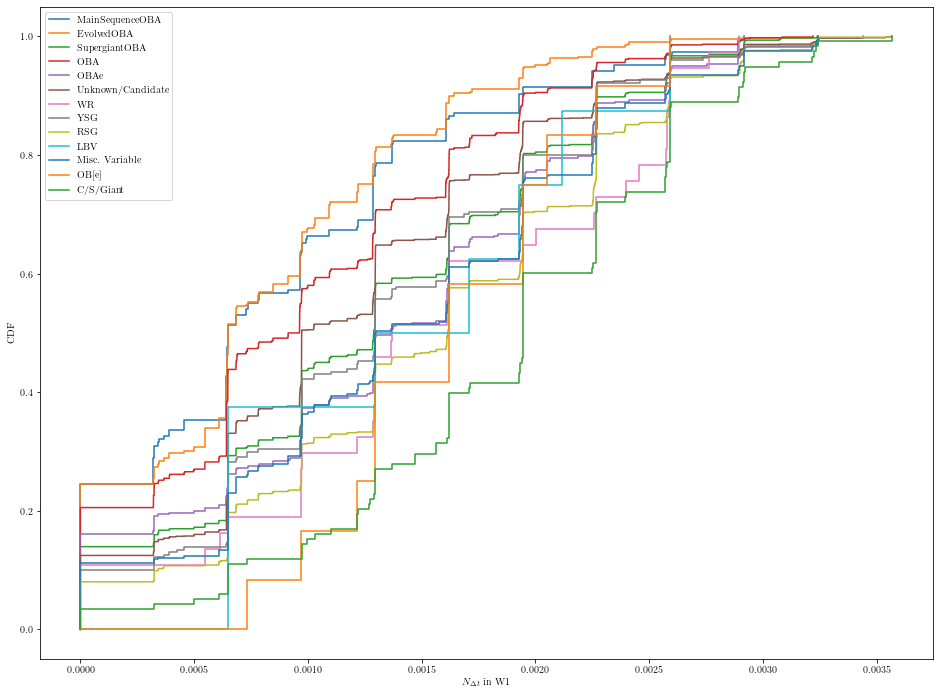

In [15]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel('$N_{\Delta t}$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

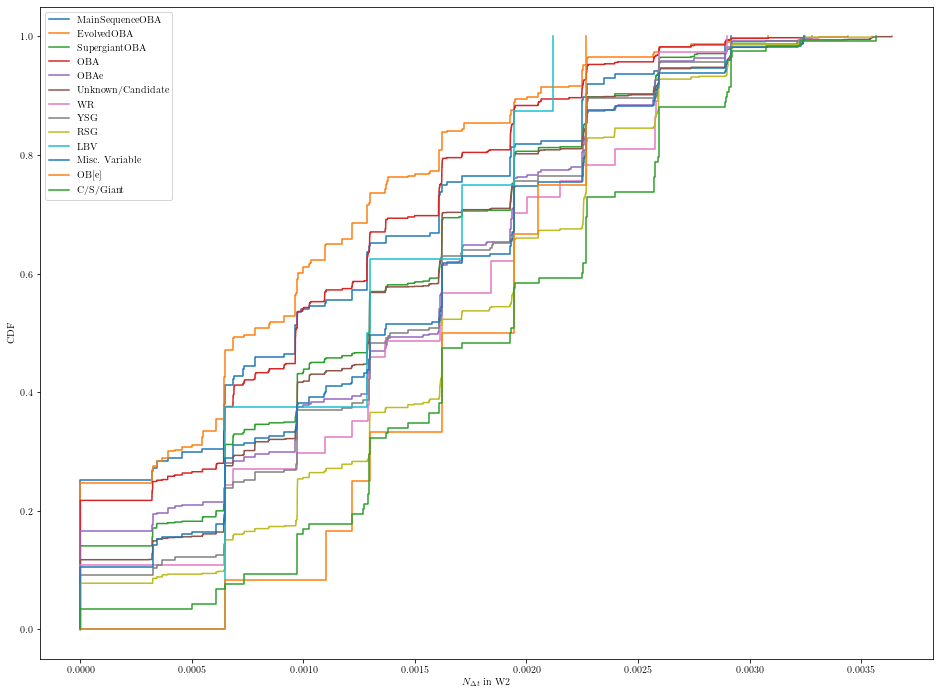

In [37]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel('$N_{\Delta t}$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

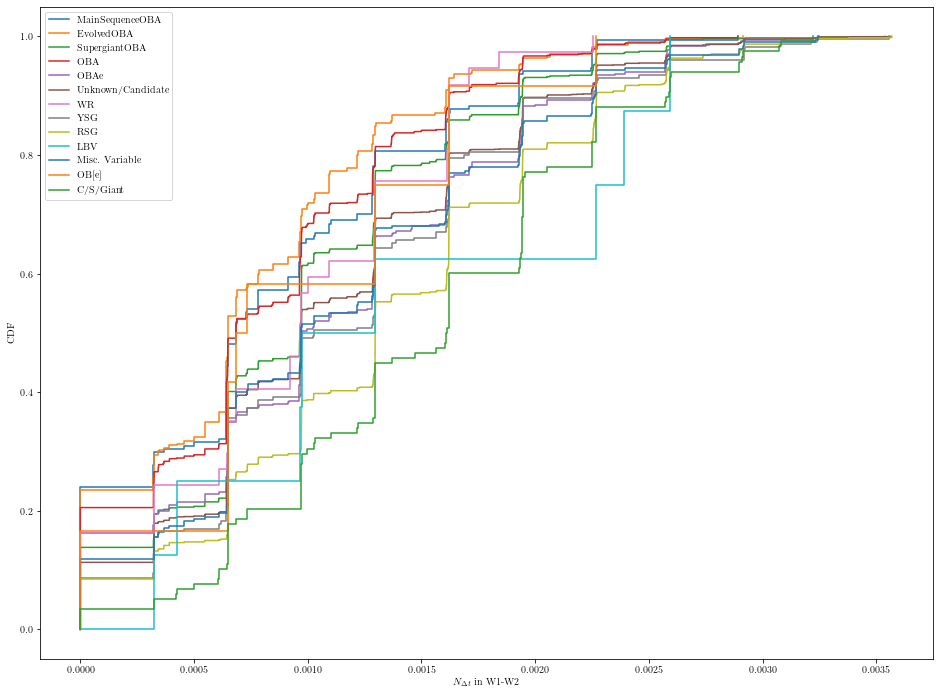

In [36]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel('$N_{\Delta t}$ in W1-W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

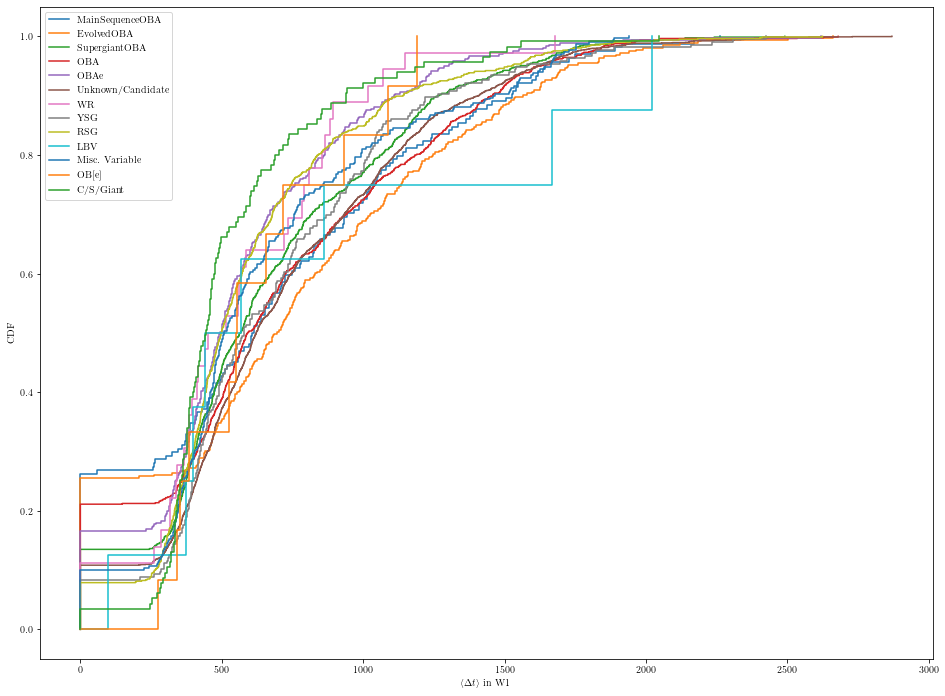

In [38]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

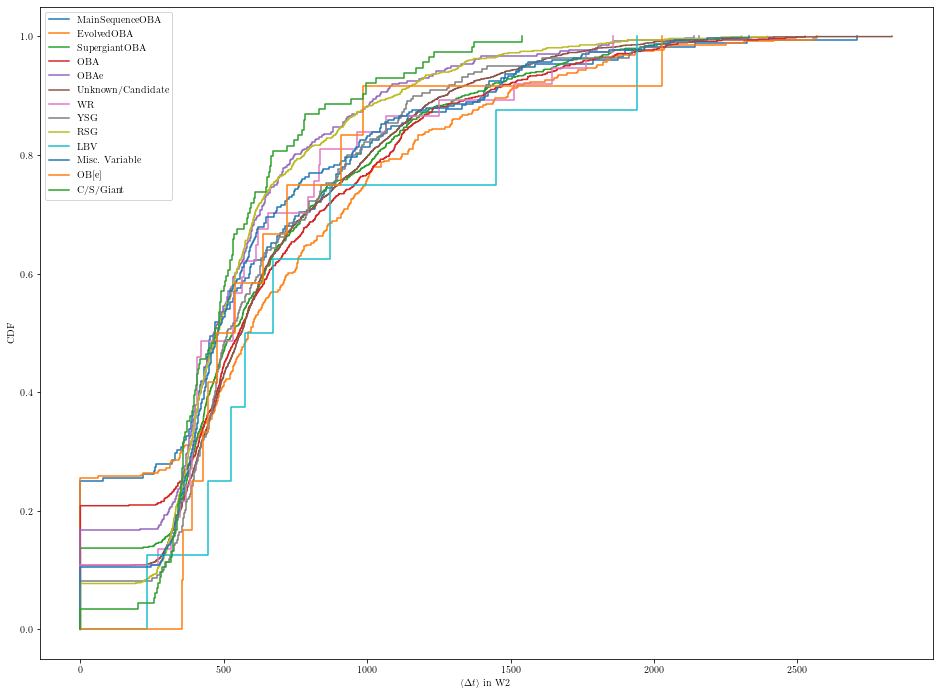

In [40]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

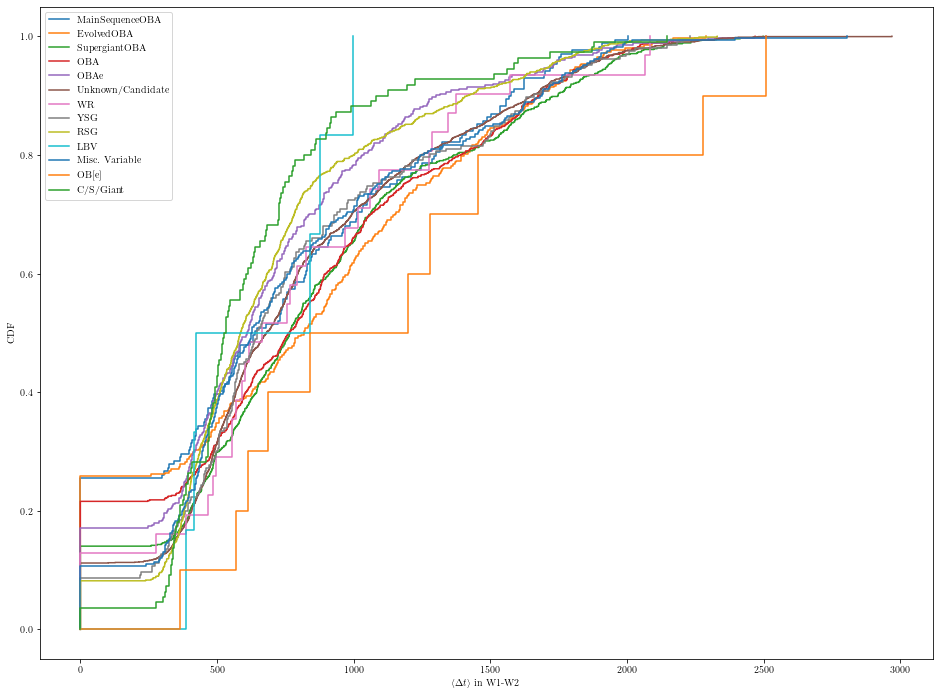

In [41]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W1-W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

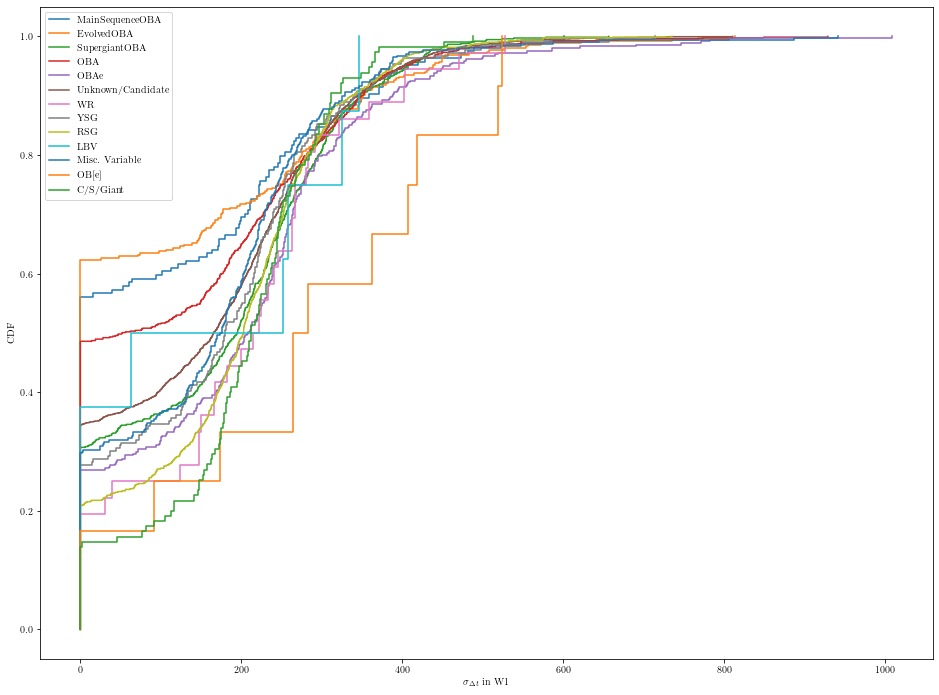

In [42]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

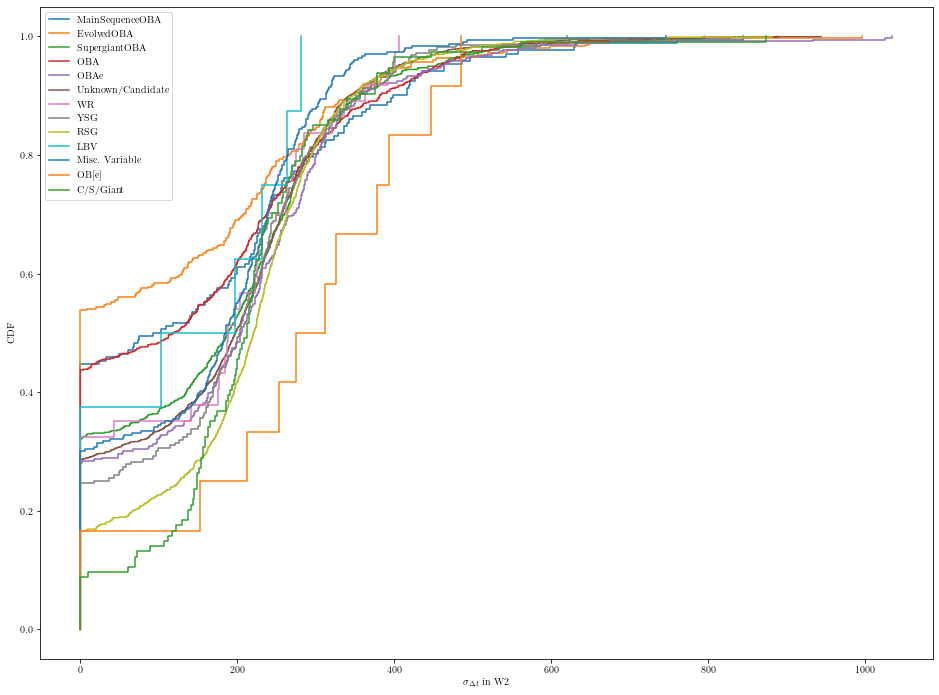

In [43]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

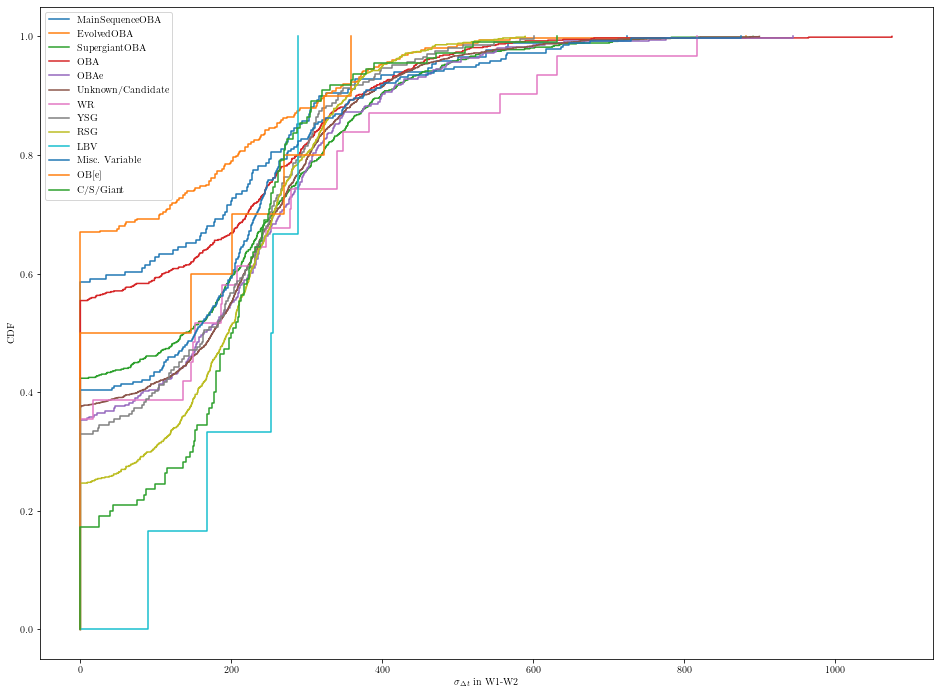

In [44]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='post',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W1-W2')
plt.ylabel('CDF')